Importing necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Loading desire dataset 

In [2]:
# Read Excel file
file_path = "C:\\Users\\sanskruti\\OneDrive\\Desktop\\medical inventory data.xlsx"
df = pd.read_excel(file_path, sheet_name='sheet1')

Negative values from dataset

In [3]:
# 4. Validate Negative Values
negatives = df[(df['Final_Sales'] < 0) | (df['Final_Cost'] < 0)]
print("\nNegative Sales or Cost Detected:\n", negatives)


Negative Sales or Cost Detected:
 Empty DataFrame
Columns: [Typeofsales, Patient_ID, Specialisation, Department, Quantity, ReturnQuantity, Final_Cost, Final_Sales, ReturnMRP, Formulation, DrugName, SubCategory, SubCategory1, billdate, Day, Month, quarter, profit]
Index: []


Feature Engineering

In [4]:
# 5. Feature Engineering
df['Net_Quantity'] = df['Quantity'] - df['ReturnQuantity']
df['Profit_Margin'] = df['profit'] / df['Final_Sales']
df['Profit_Margin'] = df['Profit_Margin'].replace([float('inf'), -float('inf')], 0).fillna(0)

df['Return_Rate'] = df['ReturnQuantity'] / df['Quantity']
df['Return_Rate'] = df['Return_Rate'].replace([float('inf'), -float('inf')], 0).fillna(0)


Exploratory Data Analysis (EDA)

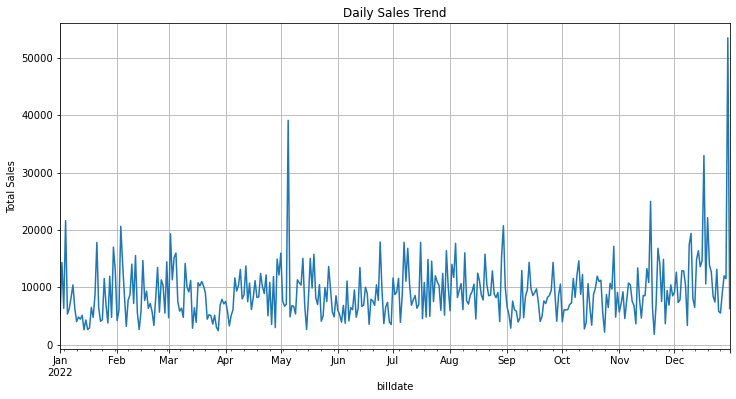

In [5]:
# 1. Sales Trend Over Time
df.groupby('billdate')['Final_Sales'].sum().plot(figsize=(12,6))
plt.title('Daily Sales Trend')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

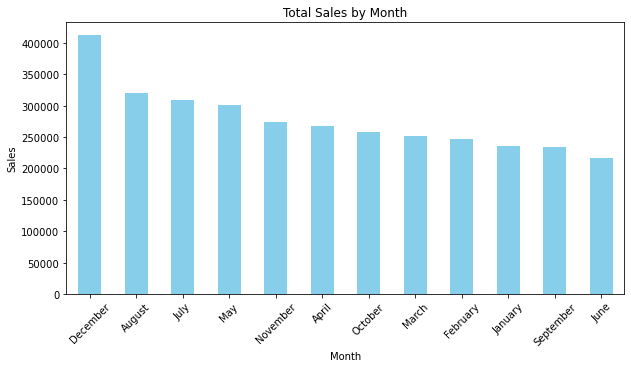

In [6]:
# 2. Sales by Month
monthly_sales = df.groupby('Month')['Final_Sales'].sum().sort_values(ascending=False)
monthly_sales.plot(kind='bar', color='skyblue', figsize=(10,5))
plt.title('Total Sales by Month')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

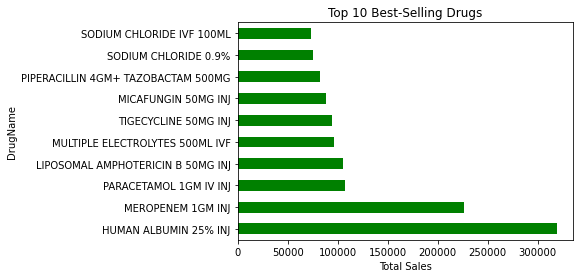

In [7]:
# 3. Top Selling Drugs
top_drugs = df.groupby('DrugName')['Final_Sales'].sum().sort_values(ascending=False).head(10)
top_drugs.plot(kind='barh', color='green')
plt.title('Top 10 Best-Selling Drugs')
plt.xlabel('Total Sales')
plt.show()


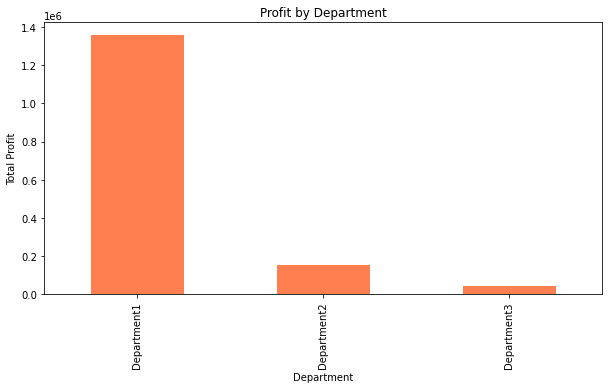

In [8]:
# 4. Department-Wise Profitability
dept_profit = df.groupby('Department')['profit'].sum().sort_values(ascending=False)
dept_profit.plot(kind='bar', figsize=(10,5), color='coral')
plt.title('Profit by Department')
plt.ylabel('Total Profit')
plt.show()

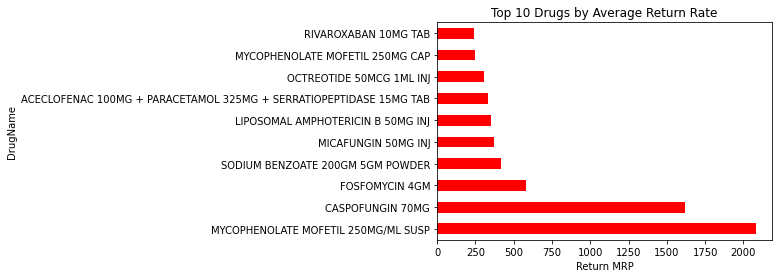

In [9]:
# 5. Return Rate Analysis
top_returns = df.groupby('DrugName')['ReturnMRP'].mean().sort_values(ascending=False).head(10)
top_returns.plot(kind='barh', color='red')
plt.title('Top 10 Drugs by Average Return Rate')
plt.xlabel('Return MRP')
plt.show()

In [10]:
# 6. Anomaly Detection — Negative Profit
anomalies = df[df['profit'] < 0]
print(f"\n⚠️ Found {len(anomalies)} Negative Profit Transactions")
print(anomalies[['DrugName', 'Final_Sales', 'Final_Cost', 'profit']].head())


⚠️ Found 1686 Negative Profit Transactions
                              DrugName  Final_Sales  Final_Cost  profit
15                     ENOXAPARIN 60MG            0         132    -132
46                     ENOXAPARIN 60MG            0          86     -86
53        CARBOXYMETHYL CELLULOSE 15ML            0          74     -74
58                  ONDANSETRON 2MG/ML            0          43     -43
66  PIPERACILLIN 4GM+ TAZOBACTAM 500MG            0          68     -68


In [11]:
print(df['DrugName'].unique())


['CEFTRIAXONE 1GM' 'SODIUM CHLORIDE 0.9%' 'PARACETAMOL 1GM IV INJ'
 'EPHEDRINE 30MG' 'THYROXINE SODIUM 25MCG TAB'
 'WATER FOR INJECTION 10ML SOLUTION' 'LIGNOCAINE HYDROCHLORIDE 2% INJ'
 'ASPIRIN 75MG' 'N-ACETYLCYSTEINE 200MG/2ML INJ' 'ENOXAPARIN 40MG'
 'HUMAN ALBUMIN 25% INJ' 'HALOPERIDOL 5MG/1ML INJ' 'ENOXAPARIN 60MG'
 'GLYCOPYRROLATE' 'LIQUID PARAFFIN + MILK OF MAGNESIA'
 'DEXTROSE 10%W/V 500ML IVF' 'SODIUM CHLORIDE IVF 100ML'
 'PROPOFOL 1% 20ML INJ' 'FLUCONAZOLE 50MG TAB' 'POLYMYXIN B INJ 500000IU'
 'LEVOSALBUTAMOL 1.25MG + IPRATROPIUM BROMIDE 500MCG RESPULES'
 'MICAFUNGIN 50MG INJ' 'FENTANYL 100MCG/2ML' 'TEICOPLANIN 400MG INJ'
 'LEVETIRACETAM 100MG/ML INJ' 'DEXTROSE 5% W/V IV FLUID'
 'CALCIUM GLUCONATE' 'PIPERACILLIN 4GM+ TAZOBACTAM 500MG'
 'CHLORHEXIDINE GLUCONATE 0.2%W/V' 'POLYETHYLENE GLYCOL POWDER'
 'SODIUM BICARBONATE 8.5% INJ' 'METOLAZONE 5MG TAB' 'MEROPENEM 1GM INJ'
 'L LEUCINS 2.3GM + L VALINE 1.5GM + L ISOLEUCINE 1.2GM SACHET'
 'NORADRENALINE 2ML INJ' 'LIPOSOMAL AMPHOTERIC

Data preparation model training and drug demand prediction

15:50:34 - cmdstanpy - INFO - Chain [1] start processing
15:50:35 - cmdstanpy - INFO - Chain [1] done processing


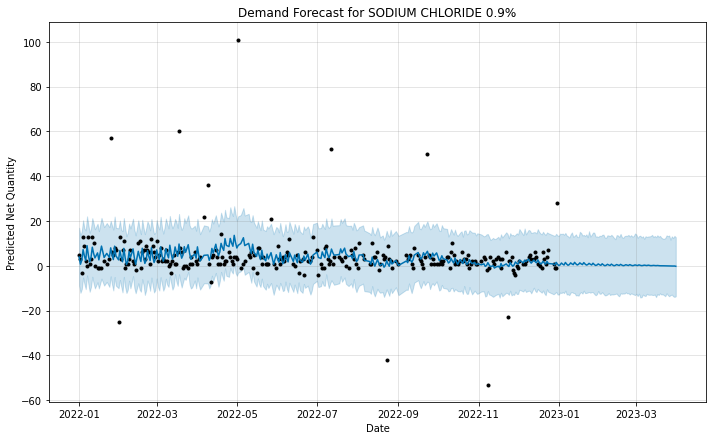

Forecast saved: Forecast_SODIUM CHLORIDE 0.9%.csv


In [12]:
from prophet import Prophet


# Step 3: Data Preparation
# Convert billdate to datetime
df['billdate'] = pd.to_datetime(df['billdate'], errors='coerce')

# Drop rows with missing billdate
df = df.dropna(subset=['billdate'])

# Create engineered features
df['Net_Quantity'] = df['Quantity'] - df['ReturnQuantity']

# Step 4: Choose One Drug for Prediction
# Make sure the drug exists in your dataset!
selected_drug = 'SODIUM CHLORIDE 0.9%'  # <-- Replace with real drug name

# Filter for selected drug
drug_data = df[df['DrugName'] == selected_drug]

# Check if there is data
if drug_data.empty:
    raise ValueError(f"No data found for drug: {selected_drug}")

# Group by Date to create time series
drug_sales = drug_data.groupby('billdate')['Net_Quantity'].sum().reset_index()
drug_sales = drug_sales.rename(columns={'billdate': 'ds', 'Net_Quantity': 'y'})

# Step 5: Train Prophet Model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')
model.fit(drug_sales)

# Step 6: Predict Future Demand
future = model.make_future_dataframe(periods=90)  # Predict 90 days ahead
forecast = model.predict(future)

# Step 7: Plot Forecast
fig = model.plot(forecast)
plt.title(f'Demand Forecast for {selected_drug}')
plt.xlabel('Date')
plt.ylabel('Predicted Net Quantity')
plt.grid(True)
plt.show()

# Step 8: Save to CSV
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv(f'Forecast_{selected_drug}.csv', index=False)
print(f"Forecast saved: Forecast_{selected_drug}.csv")


Identifying high selling drugs saving there demand prediction for 90 days and saving it in excel file 

In [13]:
import pandas as pd
from prophet import Prophet
import os
import re

# Step 1: Load Cleaned Dataset

df['billdate'] = pd.to_datetime(df['billdate'], errors='coerce')
df = df.dropna(subset=['billdate'])
df['Net_Quantity'] = df['Quantity'] - df['ReturnQuantity']

# Step 2: Identify High-Selling Drugs
threshold = 250  # minimum total sales to be considered "important"
sales_sum = df.groupby('DrugName')['Net_Quantity'].sum()
important_drugs = sales_sum[sales_sum > threshold].index.tolist()

print(f"Found {len(important_drugs)} high-selling drugs for prediction.\n")

# Step 3: Prepare Output Storage
forecast_dict = {}
summary = []

# Safe Excel Sheet Name Helper
def clean_sheet_name(name):
    return re.sub(r'[\[\]\*:/\\\?]', '_', name)[:31]

# Step 4: Loop Through Important Drugs
for drug in important_drugs:
    drug_data = df[df['DrugName'] == drug]

    drug_sales = drug_data.groupby('billdate')['Net_Quantity'].sum().reset_index()
    drug_sales = drug_sales.rename(columns={'billdate': 'ds', 'Net_Quantity': 'y'})

    if len(drug_sales.dropna()) < 2:
        summary.append({'DrugName': drug, 'Status': 'Skipped', 'Reason': 'Not enough data points'})
        continue

    try:
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode='multiplicative')
        model.fit(drug_sales)

        future = model.make_future_dataframe(periods=90)  # Predict 90 days ahead
        forecast = model.predict(future)

        forecast_dict[drug] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        summary.append({'DrugName': drug, 'Status': 'Predicted', 'Reason': 'Prediction completed'})

        print(f"Prediction done for: {drug}")

    except Exception as e:
        summary.append({'DrugName': drug, 'Status': 'Error', 'Reason': str(e)})
        print(f"Error for {drug}: {e}")

# Step 5: Save All Forecasts into One Excel File
output_file = 'Important_Drugs_Predictions.xlsx'
with pd.ExcelWriter(output_file) as writer:
    for drug, forecast_df in forecast_dict.items():
        safe_sheet_name = clean_sheet_name(drug)
        forecast_df.to_excel(writer, sheet_name=safe_sheet_name, index=False)

    # Save Summary sheet
    summary_df = pd.DataFrame(summary)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

print(f"\nAll high-selling drug predictions saved to {output_file} ")


15:50:35 - cmdstanpy - INFO - Chain [1] start processing


Found 24 high-selling drugs for prediction.



15:50:35 - cmdstanpy - INFO - Chain [1] done processing
15:50:35 - cmdstanpy - INFO - Chain [1] start processing


Prediction done for: ADRENALINE INJ 1ML


15:50:36 - cmdstanpy - INFO - Chain [1] done processing
15:50:36 - cmdstanpy - INFO - Chain [1] start processing


Prediction done for: ATRACURIUM BESYLATE 25MG/2.5ML


15:50:37 - cmdstanpy - INFO - Chain [1] done processing
15:50:37 - cmdstanpy - INFO - Chain [1] start processing
15:50:37 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: CALCIUM POLYSTYRENE SULFONATE 15GM POWDER


15:50:37 - cmdstanpy - INFO - Chain [1] start processing
15:50:37 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: CEFOPERAZONE 1GM + SULBACTAM 500MG INJ


15:50:37 - cmdstanpy - INFO - Chain [1] start processing
15:50:37 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: CEFTRIAXONE 1GM


15:50:38 - cmdstanpy - INFO - Chain [1] start processing
15:50:38 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: DEXAMETHASONE 4MG/2ML INJ


15:50:38 - cmdstanpy - INFO - Chain [1] start processing


Prediction done for: DEXTROSE 5% W/V IV FLUID


15:50:39 - cmdstanpy - INFO - Chain [1] done processing
15:50:39 - cmdstanpy - INFO - Chain [1] start processing
15:50:39 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: L LEUCINS 2.3GM + L VALINE 1.5GM + L ISOLEUCINE 1.2GM SACHET


15:50:39 - cmdstanpy - INFO - Chain [1] start processing
15:50:39 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: LEVOSALBUTAMOL/LEVALBUTEROL 0.63MG RESPULES


15:50:39 - cmdstanpy - INFO - Chain [1] start processing
15:50:39 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: LIGNOCAINE HYDROCHLORIDE 2% INJ


15:50:40 - cmdstanpy - INFO - Chain [1] start processing


Prediction done for: MEROPENEM 1GM INJ


15:50:40 - cmdstanpy - INFO - Chain [1] done processing
15:50:40 - cmdstanpy - INFO - Chain [1] start processing
15:50:40 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: MULTIPLE ELECTROLYTES 500ML IVF


15:50:40 - cmdstanpy - INFO - Chain [1] start processing
15:50:40 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: NORADRENALINE 2ML INJ


15:50:41 - cmdstanpy - INFO - Chain [1] start processing
15:50:41 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: ONDANSETRON 2MG/ML


15:50:41 - cmdstanpy - INFO - Chain [1] start processing
15:50:41 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: PANTOPRAZOLE 40MG INJ


15:50:41 - cmdstanpy - INFO - Chain [1] start processing


Prediction done for: PARACETAMOL 1GM IV INJ


15:50:41 - cmdstanpy - INFO - Chain [1] done processing
15:50:42 - cmdstanpy - INFO - Chain [1] start processing
15:50:42 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: PIPERACILLIN 4GM+ TAZOBACTAM 500MG


15:50:42 - cmdstanpy - INFO - Chain [1] start processing


Prediction done for: POTASSIUM CHLORIDE 150MG


15:50:42 - cmdstanpy - INFO - Chain [1] done processing
15:50:42 - cmdstanpy - INFO - Chain [1] start processing


Prediction done for: SALBUTAMOL 2.5MG


15:50:53 - cmdstanpy - INFO - Chain [1] done processing
15:50:53 - cmdstanpy - INFO - Chain [1] start processing


Prediction done for: SEVOFLURANE


15:50:53 - cmdstanpy - INFO - Chain [1] done processing
15:50:54 - cmdstanpy - INFO - Chain [1] start processing


Prediction done for: SEVOFLURANE 99.97%


15:50:54 - cmdstanpy - INFO - Chain [1] done processing
15:50:54 - cmdstanpy - INFO - Chain [1] start processing
15:50:54 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: SODIUM CHLORIDE 0.9%


15:50:54 - cmdstanpy - INFO - Chain [1] start processing


Prediction done for: SODIUM CHLORIDE IVF 100ML


15:50:54 - cmdstanpy - INFO - Chain [1] done processing


Prediction done for: WATER FOR INJECTION 10ML SOLUTION

All high-selling drug predictions saved to Important_Drugs_Predictions.xlsx 
